In [ ]:
import numpy as np
import pandas as pd
import os

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# clustering
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
import hdbscan
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from minisom import MiniSom
from scipy.spatial import Voronoi

# gif plotting
import plotly.graph_objects as go
import plotly.io as pio
import imageio.v2 as imageio

# astro
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
preds = pd.read_parquet('impartial_xp_pred_cnn.parquet')

### Convert to galactic coordinates

In [3]:
def convert_to_galactic(df):
    coords = SkyCoord(ra=df['ra'].values * u.deg, dec=df['dec'].values * u.deg, frame='icrs')
    df['l_galactic'] = coords.galactic.l.deg
    df['b_galactic'] = coords.galactic.b.deg
    return df
preds = convert_to_galactic(preds)

### Merge parallax data

In [4]:
parallax = pd.read_csv('./results-parallax.csv')

In [5]:
sources = pd.merge(preds, parallax, on='source_id')

In [6]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204493 entries, 0 to 1204492
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   source_id            1204493 non-null  int64  
 1   ra                   1204493 non-null  float64
 2   dec                  1204493 non-null  float64
 3   flux                 1204493 non-null  object 
 4   prediction           1204493 non-null  float32
 5   l_galactic           1204493 non-null  float64
 6   b_galactic           1204493 non-null  float64
 7   parallax             1204421 non-null  float64
 8   parallax_error       1204421 non-null  float64
 9   parallax_over_error  1204421 non-null  float64
dtypes: float32(1), float64(7), int64(1), object(1)
memory usage: 87.3+ MB


### Calculate distance

In [7]:
# Filter sources with parallax_over_error >= 3
sources = sources[sources['parallax_over_error'] >= 3].copy()
sources.shape

(1058543, 10)

In [8]:
sources['d'] = 1 / sources['parallax']
sources['d_error'] = sources['parallax_error'] / sources['parallax']**2

In [9]:
sources = sources.drop(columns=['ra', 'dec', 'flux', 'parallax', 'parallax_error', 'parallax_over_error'])
sources.shape

(1058543, 6)

In [10]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058543 entries, 0 to 1204492
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   source_id   1058543 non-null  int64  
 1   prediction  1058543 non-null  float32
 2   l_galactic  1058543 non-null  float64
 3   b_galactic  1058543 non-null  float64
 4   d           1058543 non-null  float64
 5   d_error     1058543 non-null  float64
dtypes: float32(1), float64(4), int64(1)
memory usage: 52.5 MB


In [11]:
sources.to_parquet('./impartial_cnn_preds_filtered.parquet')

## Plot

In [12]:
def clustering_algorithm(coords, algo:str = 'DBSCAN'):
    if algo == 'DBSCAN':
        db = DBSCAN(eps=0.5, min_samples=10).fit(coords)
        return db.labels_
    elif algo == 'HDBSCAN':
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(coords)
        return clusterer.labels_
    elif algo == 'KMEANS':
        kmeans = KMeans(n_clusters=5).fit(coords)
        return kmeans.labels_
    elif algo == 'GMM':
        gmm = GaussianMixture(n_components=5).fit(coords)
        return gmm.predict(coords)
    elif algo == 'AGGLO':
        agglo = AgglomerativeClustering(n_clusters=5).fit(coords)
        return agglo.labels_
    elif algo == 'MEANSHIFT':
        mean_shift = MeanShift().fit(coords)
        return mean_shift.labels_
    elif algo == 'OPTICS':
        optics = OPTICS(min_samples=10).fit(coords)
        return optics.labels_
    elif algo == 'SOM':
        som = MiniSom(10, 10, 3, sigma=1.0, learning_rate=0.5)
        som.train_random(coords, 100)  
        return [som.winner(c) for c in coords]
    # elif algo == 'VOR':
    #     vor = Voronoi(coords)
    #     return
    # elif algo == 'TSNE':
    #     tsne = TSNE(n_components=3).fit_transform(coords)
    #     return 

In [13]:
def galactic_to_cartesian(l, b, distance):
    l_rad = np.deg2rad(l)
    b_rad = np.deg2rad(b)
    x = distance * np.cos(b_rad) * np.sin(l_rad)
    y = distance * np.cos(b_rad) * np.cos(l_rad)
    z = distance * np.sin(b_rad)
    return x, y, z

In [21]:
def create_gif(coords, predictions, labels=None, coord_type='cartesian', num_frames=36, output_file='scatter_plot.gif', camera_angle=0.5, zoom=1.5):
    """
    Creates an animated GIF of a rotating 3D scatter plot for the given coordinates.
    
    Parameters:
    - coords: List of tuples/lists containing the coordinates.
    - predictions: List of prediction values corresponding to the points.
    - labels: Cluster labels for the points.
    - coord_type: Type of coordinates ('cartesian', 'ra_dec', 'spherical').
    - num_frames: Number of frames for the rotation animation.
    - output_file: Name of the output GIF file.
    """

    x, y, z = zip(*coords)

    frames = []
    temp_dir = 'temp_frames'
    os.makedirs(temp_dir, exist_ok=True)
    
    sizes = [1 if pred == 0 else 8 for pred in predictions]
    if labels is not None:
        unique_labels = list(set(labels))
        color_map = {label: color for label, color in zip(unique_labels, ['white', 'red', 'green', 'blue', 'yellow', 'gray'])}
        colors = [color_map.get(label, 'gray') for label in labels]
    else:
        colors = ['white' if pred == 0.0 else 'red' for pred in predictions]
    
    for i in range(num_frames):
        angle = 360 * i / num_frames
        fig = go.Figure(data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=sizes,
                color=colors,
                opacity=1.0,
                line=dict(width=0)
            ),
            hoverinfo='none'
        )])
        
        fig.update_layout(
            scene=dict(
                xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, zeroline=False, title=''),
                yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, zeroline=False, title=''),
                zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, zeroline=False, title=''),
                camera_eye=dict(x=np.sin(np.deg2rad(angle)), y=np.cos(np.deg2rad(angle)), z=camera_angle)
            ),
            paper_bgcolor='black',
            plot_bgcolor='black',
            scene_bgcolor='black',
            margin=dict(l=0, r=0, b=0, t=0)
        )
        
        frame_file = f"{temp_dir}/frame_{i:03d}.png"
        fig.write_image(frame_file)
        frames.append(imageio.imread(frame_file))
    
    imageio.mimsave(output_file, frames, duration=0.01)
    for frame_file in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, frame_file))
    os.rmdir(temp_dir)

In [42]:
def plot_interactive_3d(coords, predictions, labels=None, camera_angle=0.85, zoom=1.0):
    """
    Function to create an interactive 3D scatter plot using Plotly.
    Allows users to explore the plot before creating a GIF.
    
    Args:
        coords (list of tuples): List of (x, y, z) coordinates.
        predictions (list): List of predictions, e.g., [0, 1, 0].
        labels (list, optional): Optional list of labels.
        camera_angle (float): Camera z position.
    """
    x, y, z = zip(*coords)
    

    ################################################################################################################################################
     # Calculate the Euclidean distance of each point from the origin (0, 0, 0)
    distances = np.sqrt(np.array(x)**2 + np.array(y)**2 + np.array(z)**2)
    
    # Normalize distances for gradient mapping (max distance becomes 1, min distance becomes 0)
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    norm_distances = (distances - min_distance) / (max_distance - min_distance)

     # Create gradient of red colors based on distance (closer = deeper red, further = brighter red)
    gradient_colors = [cm.Reds(1 - norm_dist) for norm_dist in norm_distances]  # Inverted to make closer stars darker
    ###############################################################################################################################################

    sizes = [1 if pred == 0 else 8 for pred in predictions]

    if labels is not None:
        unique_labels = list(set(labels))
        color_map = {label: color for label, color in zip(unique_labels, ['crimson', 'green', 'sienna', 'yellow', 'lavender', 'darkblue', 'orangered', 
                                                                          'yellowgreen', 'hotpink', 'coral', 'steelblue', 'blue', 'fuchsia'])}
        colors = [color_map.get(label, 'gray') for label in labels]
    else:
        # colors = ['white' if pred == 0.0 else 'red' for pred in predictions]
        colors = ['white' if pred == 0 else f'rgba({int(255 * r)}, {int(255 * g)}, {int(255 * b)}, 1.0)' 
                  for pred, (r, g, b, _) in zip(predictions, gradient_colors)]
    
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=sizes,
            color=colors,
            opacity=1.0,
            line=dict(width=0)
        ),
        hoverinfo='none'
    )])
    
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, zeroline=False, title='', showspikes=False),
            yaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, zeroline=False, title='', showspikes=False),
            zaxis=dict(showbackground=False, showgrid=False, showline=False, showticklabels=False, zeroline=False, title='', showspikes=False),
            camera_eye=dict(x=zoom*np.sin(np.deg2rad(45)), y=zoom*np.cos(np.deg2rad(45)), z=zoom*camera_angle)  # Static camera angle
        ),
        paper_bgcolor='black',
        plot_bgcolor='black',
        scene_bgcolor='black',
        margin=dict(l=0, r=0, b=0, t=0),
        height=700
    )
    # pio.renderers.default = 'browser'
    pio.write_json(fig, 'interactive_plot_3d.json')
    fig.show()

### Plot options

In [16]:
num_sources = 1_000_000

sources_subset, _ = train_test_split(
    sources, 
    train_size=num_sources, 
    stratify=sources['prediction'], 
    random_state=42
)

In [17]:
# Apply conversion to sources_subset
sources_subset['x'], sources_subset['y'], sources_subset['z'] = zip(*sources_subset.apply(
    lambda row: galactic_to_cartesian(row['l_galactic'], row['b_galactic'], row['d']), axis=1))

In [18]:
sources_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 213162 to 216903
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   source_id   1000000 non-null  int64  
 1   prediction  1000000 non-null  float32
 2   l_galactic  1000000 non-null  float64
 3   b_galactic  1000000 non-null  float64
 4   d           1000000 non-null  float64
 5   d_error     1000000 non-null  float64
 6   x           1000000 non-null  float64
 7   y           1000000 non-null  float64
 8   z           1000000 non-null  float64
dtypes: float32(1), float64(7), int64(1)
memory usage: 72.5 MB


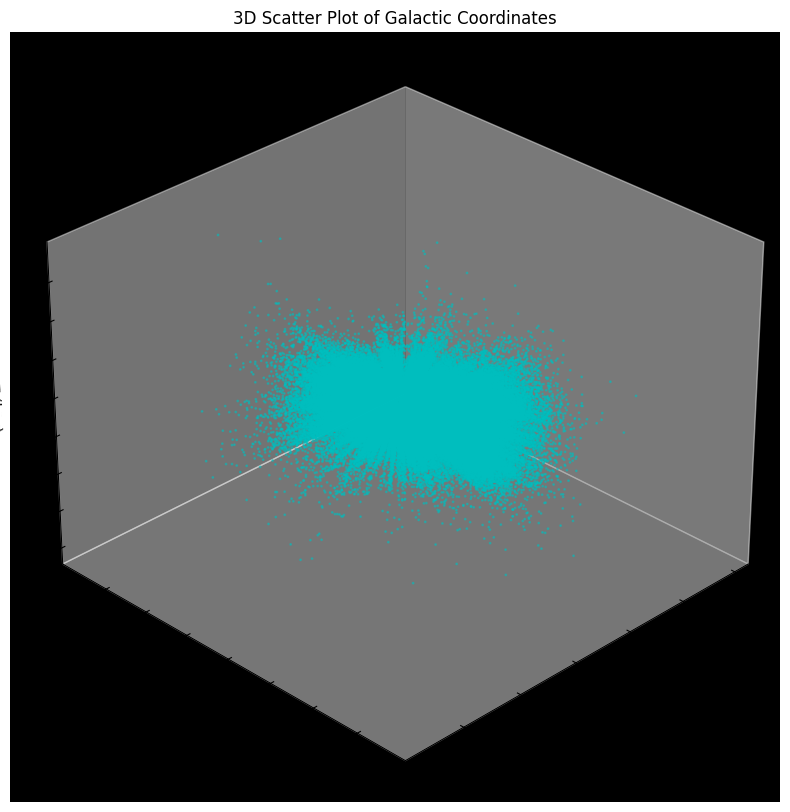

In [28]:
# static plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sources_subset[sources_subset['prediction'] == 1.0]['x'],
           sources_subset[sources_subset['prediction'] == 1.0]['y'],
           sources_subset[sources_subset['prediction'] == 1.0]['z'],
           s=8, c='r', marker='o', label='Prediction 1.0')

ax.scatter(sources_subset[sources_subset['prediction'] == 0.0]['x'],
           sources_subset[sources_subset['prediction'] == 0.0]['y'],
           sources_subset[sources_subset['prediction'] == 0.0]['z'],
           s=1, c='c', marker='o', alpha=0.5, label='Prediction 0.0')

ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

ax.grid(False)
ax.set_facecolor('black')

ax.set_title('3D Scatter Plot of Galactic Coordinates')
ax.view_init(elev=30, azim=45)

plt.show()

In [43]:
# interactive plot
distance_threshold = 1.0  # For low mass stars
origin_distance_threshold = 7.75  # For massive stars near the origin

# Get coordinates of massive stars
massive_stars = sources_subset[sources_subset['prediction'] == 1.0]
massive_coords = massive_stars[['x', 'y', 'z']].values

# Get labels (clusters)
labels = clustering_algorithm(massive_coords, algo='DBSCAN')

# Filter out low mass stars within the distance threshold from massive stars
def is_within_threshold(row):
    distances = np.sqrt((massive_coords[:, 0] - row['x'])**2 + 
                        (massive_coords[:, 1] - row['y'])**2 + 
                        (massive_coords[:, 2] - row['z'])**2)
    return np.all(distances > distance_threshold)

# Apply filtering for low mass stars
low_mass_stars = sources_subset[sources_subset['prediction'] == 0.0].loc[
    sources_subset[sources_subset['prediction'] == 0.0].apply(is_within_threshold, axis=1)
]

# Further filter high mass stars near the origin
massive_stars_ = massive_stars[massive_stars.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2 + row['z']**2) > origin_distance_threshold, axis=1)]

# Combine massive stars and filtered low mass stars
sources_subset = pd.concat([massive_stars_, low_mass_stars])

# apply conversion to sources_subset
sources_subset['x'], sources_subset['y'], sources_subset['z'] = zip(*sources_subset.apply(lambda row: galactic_to_cartesian(row['l_galactic'], row['b_galactic'], row['d']), axis=1))

coords = list(zip(sources_subset['x'], sources_subset['y'], sources_subset['z']))
predictions = sources_subset['prediction'].tolist()

plot_interactive_3d(coords, predictions, camera_angle=0.5)

In [ ]:
# plain gif
coords = list(zip(sources_subset['x'], sources_subset['y'], sources_subset['z']))
predictions = sources_subset['prediction'].tolist()

create_gif(coords, predictions)

In [23]:
# with clustering
distance_threshold = 1.0  # For massive stars
origin_distance_threshold = 7.75  # For low mass stars near the origin

# Get coordinates of massive stars
massive_stars = sources_subset[sources_subset['prediction'] == 1.0]
massive_coords = massive_stars[['x', 'y', 'z']].values

# Get labels (clusters)
labels = clustering_algorithm(massive_coords, algo='HDBSCAN')

# Filter out low mass stars within the distance threshold from massive stars
def is_within_threshold(row):
    distances = np.sqrt((massive_coords[:, 0] - row['x'])**2 + 
                        (massive_coords[:, 1] - row['y'])**2 + 
                        (massive_coords[:, 2] - row['z'])**2)
    return np.all(distances > distance_threshold)

# Apply filtering for low mass stars
low_mass_stars = sources_subset[sources_subset['prediction'] == 0.0].loc[
    sources_subset[sources_subset['prediction'] == 0.0].apply(is_within_threshold, axis=1)
]

# Further filter high mass stars near the origin
massive_stars_ = massive_stars[massive_stars.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2 + row['z']**2) > origin_distance_threshold, axis=1)]

# Combine massive stars and filtered low mass stars
sources_subset = pd.concat([massive_stars_, low_mass_stars])

# apply conversion to sources_subset
sources_subset['x'], sources_subset['y'], sources_subset['z'] = zip(*sources_subset.apply(lambda row: galactic_to_cartesian(row['l_galactic'], row['b_galactic'], row['d']), axis=1))

coords = list(zip(sources_subset['x'], sources_subset['y'], sources_subset['z']))
predictions = sources_subset['prediction'].tolist()

create_gif(coords, predictions, num_frames=120, camera_angle=0.2)